# Apache Arrow shared between Python and R with rpy2

The Python package shown here is available at:
https://github.com/rpy2/rpy2-arrow

In [1]:
import pyarrow
import pyarrow.dataset as ds
import rpy2_arrow.pyarrow_rarrow as pyra

Our dataset in the NYC taxi one made available to download in the Parquet format by Ursa Labs.

In [2]:
DATA_PATH = 'nyc-taxi'

## Setup: Get a dataset

Most will not have that data already available locally in directories. We use a Python
translation of the code as https://ursalabs.org/arrow-r-nightly/articles/dataset.html
to fetch the data.

In [3]:
# This allows download an incomplete dataset
# in the interest of time. Set it to None or -1
# to download the complete dataset.
MAX_NMONTHS = 10

import os
import urllib.parse
import urllib.request
import shutil

BUCKET = 'https://ursa-labs-taxi-data.s3.us-east-2.amazonaws.com'
paths = []
print('     |            |')
for year in range(2009, 2020):
    if len(paths) == MAX_NMONTHS:
        print()
        break
    print(f'{year} ', end='', flush=True)
    if year == 2019:
        # We only have through June 2019 there
        months = range(1, 7)
    else:
        months = range(1, 13)
    for month in months:
        if len(paths) == MAX_NMONTHS:
            print()
            break
        month_str = f'{month:02d}'
        year_str = str(year)
        url = urllib.parse.urljoin(BUCKET, '/'.join((year_str, month_str, 'data.parquet')))
        filename = os.path.join(DATA_PATH, year_str, month_str, 'data.parquet')
        if os.path.exists(filename):
            print('s', end='', flush=True)
            paths.append(filename)
            continue
        print('D', end='', flush=True)
        os.makedirs(os.path.join(DATA_PATH, year_str, month_str))
        with urllib.request.urlopen(url) as response, open(filename, 'wb') as output_file:
            shutil.copyfileobj(response, output_file)
        paths.append(filename)
    print()


     |            |
2009 ssssssssss




## We are ready, let's load a dataset

The dataset is read using `pyarrow.dataset`:

In [4]:
dataset = ds.dataset(paths, format='parquet')
dataset

The following line reads the dataset into an Arrow table. Depending on the size
of the data this may require a lot of memory so we apply a filter (check the relevant documentation
for more details: https://arrow.apache.org/docs/python/dataset.html).

In [5]:
tbl = dataset.to_table(filter=ds.field('tip_amount') > 10, batch_size=5E6)
tbl.shape

(268966, 18)

The table has a schema that describes types in its content.

In [6]:
tbl.schema.types

[DataType(string),
 TimestampType(timestamp[us]),
 TimestampType(timestamp[us]),
 DataType(int8),
 DataType(float),
 DataType(float),
 DataType(float),
 DataType(null),
 DataType(string),
 DataType(float),
 DataType(float),
 DataType(string),
 DataType(float),
 DataType(float),
 DataType(float),
 DataType(float),
 DataType(float),
 DataType(float)]

Each column is an array (this is a column-oriented format), or more specically a chunked array.

In [7]:
import timeit
N = 3
for col_i in (0, 1, 5):
    print(f'Column: {tbl.schema.types[col_i]}')
    t_getitem = timeit.timeit(lambda: tbl[col_i], number=N) / N
    print(f'    getitem: {t_getitem:.2e}s', end='', flush=True)
    array = tbl[col_i]
    t_convert = timeit.timeit(lambda: pyra.converter.py2rpy(array), number=N) / N
    print(f' to R: {t_convert:.2e}s')

Column: string
    getitem: 1.83e-04s2173
rarrow.ChunkedArray: 0.015054464340209961
2173
rarrow.ChunkedArray: 0.008445978164672852
2173
rarrow.ChunkedArray: 0.008262395858764648
 to R: 1.54e+00s
Column: timestamp[us]
    getitem: 6.29e-06s2173
rarrow.ChunkedArray: 0.008836030960083008
2173
rarrow.ChunkedArray: 0.009700775146484375
2173
rarrow.ChunkedArray: 0.008553266525268555
 to R: 1.39e+00s
Column: float
    getitem: 4.24e-06s2173
rarrow.ChunkedArray: 0.008428812026977539
2173
rarrow.ChunkedArray: 0.008717060089111328
2173
rarrow.ChunkedArray: 0.01002192497253418
 to R: 1.40e+00s


We can also convert the Arrow table directly. Note that it takes the cumulated time required to convert each one of the columns.

In [8]:
%%time 
r_tbl = pyra.converter.py2rpy(tbl)

2173
rarrow.ChunkedArray: 0.009516716003417969
2173
rarrow.ChunkedArray: 0.009968757629394531
2173
rarrow.ChunkedArray: 0.009840250015258789
2173
rarrow.ChunkedArray: 0.010234832763671875
2173
rarrow.ChunkedArray: 0.010568380355834961
2173
rarrow.ChunkedArray: 0.010580062866210938
2173
rarrow.ChunkedArray: 0.012594938278198242
2173
rarrow.ChunkedArray: 0.0105438232421875
2173
rarrow.ChunkedArray: 0.010989665985107422
2173
rarrow.ChunkedArray: 0.010976314544677734
2173
rarrow.ChunkedArray: 0.008070945739746094
2173
rarrow.ChunkedArray: 0.008041143417358398
2173
rarrow.ChunkedArray: 0.008098125457763672
2173
rarrow.ChunkedArray: 0.008308172225952148
2173
rarrow.ChunkedArray: 0.011569023132324219
2173
rarrow.ChunkedArray: 0.008256196975708008
2173
rarrow.ChunkedArray: 0.00997161865234375
2173
rarrow.ChunkedArray: 0.010275840759277344
CPU times: user 25.3 s, sys: 16.2 ms, total: 25.3 s
Wall time: 25.3 s


This is disappointingly slow. We can go **much** faster by first combining the chunks.

In [9]:
%%time
cb_tbl = tbl.combine_chunks()
r_tbl = pyra.converter.py2rpy(cb_tbl)

1
rarrow.ChunkedArray: 0.0012023448944091797
1
rarrow.ChunkedArray: 0.0009665489196777344
1
rarrow.ChunkedArray: 0.0008852481842041016
1
rarrow.ChunkedArray: 0.0008819103240966797
1
rarrow.ChunkedArray: 0.0008609294891357422
1
rarrow.ChunkedArray: 0.0008563995361328125
1
rarrow.ChunkedArray: 0.000823974609375
1
rarrow.ChunkedArray: 0.0008325576782226562
1
rarrow.ChunkedArray: 0.0008220672607421875
1
rarrow.ChunkedArray: 0.0007770061492919922
1
rarrow.ChunkedArray: 0.0007734298706054688
1
rarrow.ChunkedArray: 0.0007355213165283203
1
rarrow.ChunkedArray: 0.0007584095001220703
1
rarrow.ChunkedArray: 0.0006628036499023438
1
rarrow.ChunkedArray: 0.0009865760803222656
1
rarrow.ChunkedArray: 0.0007016658782958984
1
rarrow.ChunkedArray: 0.0006785392761230469
1
rarrow.ChunkedArray: 0.0006563663482666016
CPU times: user 81.2 ms, sys: 42 µs, total: 81.3 ms
Wall time: 78.8 ms


The table can then used in R, allowing to take advantage of individual strengths in a data science team
(some prefer writing R code) or libraries in R for which there is arguably no matching equivalent in Python.

In [10]:
%load_ext rpy2.ipython

In [11]:
%%R -i r_tbl
print(class(r_tbl))

[1] "Table"       "ArrowObject" "R6"         


In [12]:
%%R -i r_tbl

library(dplyr, warn.conflicts = FALSE)
r_tbl %>%
  mutate(tip_group = round(tip_amount / 5) * 5) %>%
  count(tip_group)

# A tibble: 19 x 2
   tip_group      n
       <dbl>  <int>
 1        10 148691
 2        15  74797
 3        20  22335
 4        25   7635
 5        30   4812
 6        35   2589
 7        40   1737
 8        45   1119
 9        50   1552
10        55   1079
11        60    785
12        65    350
13        70    323
14        75    253
15        80    284
16        85    145
17        90    201
18        95    102
19       100    177


R[write to console]: Loading required package: viridisLite



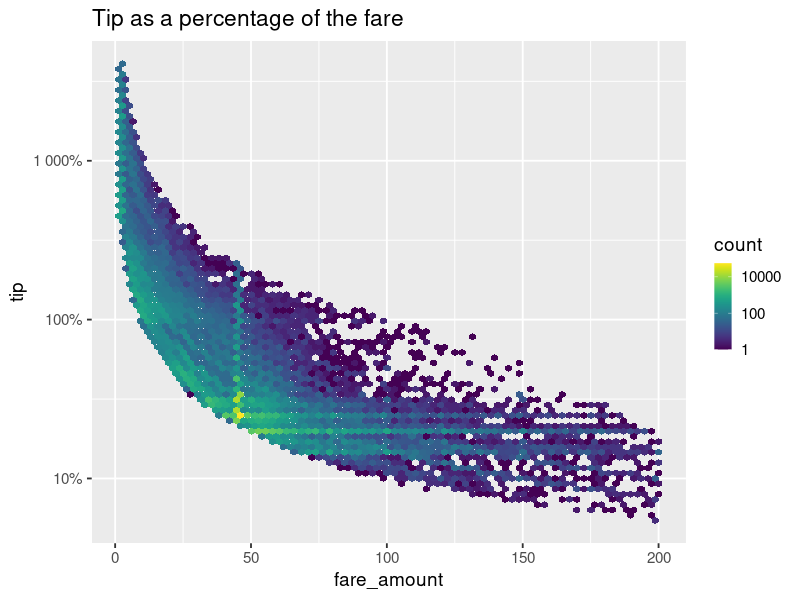

In [13]:
%%R -w 800 -h 600 --type cairo-png
library(ggplot2, warn.conflicts = FALSE)
library(viridis)
options(bitmapType="cairo")
X11.options(antialias = "subpixel")
p <- ggplot(r_tbl %>% collect()) +
  geom_hex(aes(x = fare_amount, y = tip_amount/fare_amount),
           bins = 75) +
  scale_fill_viridis(trans="log10") +
  scale_y_continuous("tip", labels = scales::percent, trans="log10") +
  ggtitle("Tip as a percentage of the fare") + 
  theme_gray(base_size=19)
print(p)